<a href="https://colab.research.google.com/github/dorj222/sketch-enhancer/blob/main/gradio_sketch_enhancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Image2Image Pipeline for Stable Diffusion using Gradio**

In [1]:
!nvidia-smi

Fri Oct 13 12:59:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -qq -U transformers ftfy gradio diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.6 MB/s eta 0:00:0

In [3]:
!pip install -qq "ipywidgets>=7,<8"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.3 MB/s eta 0:00:00


In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
import inspect
import warnings
from typing import List, Optional, Union

import torch
from torch import autocast
from tqdm.auto import tqdm

from diffusers import StableDiffusionImg2ImgPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [6]:
device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
  'CompVis/stable-diffusion-v1-4',
    revision="fp16",
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)
# pipe = pipe.

vae/diffusion_pytorch_model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [7]:
import requests
from io import BytesIO
from PIL import Image

url = "https://th.bing.com/th/id/OIP.ohGkZC2yTgsR4wv6GNnADAHaFu?pid=ImgDet&rs=1"

response = requests.get(url)
init_img = Image.open(BytesIO(response.content)).convert("RGB")
init_img = init_img.resize((768, 512))
init_img
print(type(init_img))

<class 'PIL.Image.Image'>


In [10]:
#Define the prompt
prompt = "a steampunk car in 1800s"

In [11]:
generator = torch.Generator(device=device).manual_seed(1024)
with autocast("cuda"):
    image = pipe(prompt=prompt, image=init_img, strength=0.75, guidance_scale=7.5, generator=generator).images[0]

  0%|          | 0/37 [00:00<?, ?it/s]

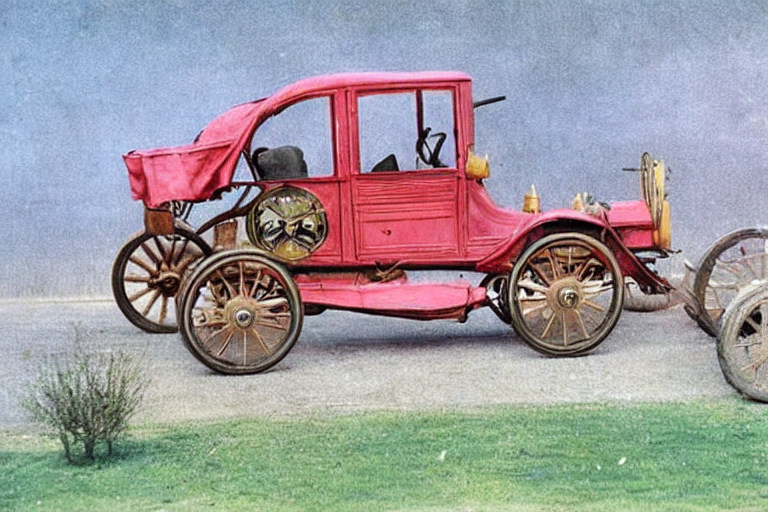

In [12]:
image

**Import Gradio library and required dependencies**

In [13]:
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from PIL import Image as PILImage

**Define a folder to save the sketches**

In [14]:
save_folder = "/content/sketches"  # Use an accessible directory in Colab
!mkdir -p $save_folder

In [36]:
def sepia(sketch):
    # Generate a unique filename
    filename = f"{save_folder}/sketch.png"

    # Save the sketch as a PNG file
    plt.imsave(filename, sketch, cmap="gray")

    # Display the saved image using IPython.display
    display(Image(filename=filename))

**Define a prompt here**

In [37]:
prompt="a black steampunk house"

In [28]:
def save_as_pil_image(sketch):
    # Generate a unique filename
    filename = f"{save_folder}/sketch.png"

    # Save the sketch as a PNG file
    plt.imsave(filename, sketch, cmap="gray")

    # Open the saved image using PIL
    saved_image = PILImage.open(filename)

    generator = torch.Generator(device=device).manual_seed(1024)
    # return_image
    with autocast("cuda"):
        return_image = pipe(prompt=prompt, image=init_img, strength=0.75, guidance_scale=7.5, generator=generator).images[0]

    return return_image

**Draw here the initial input sketch**

In [39]:
sp =gr.Paint(label="Draw Here", brush_radius=2, type="pil", shape=(240, 240))
sepia_img = gr.Interface(fn=save_as_pil_image, inputs=sp, outputs="image", share=True).launch(debug=True);

<ipython-input-39-e910d4b7f6fc>:2: GradioUnusedKwargWarning: You have unused kwarg parameters in Interface, please remove them: {'share': True}
  sepia_img = gr.Interface(fn=save_as_pil_image, inputs=sp, outputs="image", share=True).launch(debug=True);


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://bd2da8cfe4cc61454f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


  0%|          | 0/37 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://bd2da8cfe4cc61454f.gradio.live
